In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import timedelta
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


In [19]:
# File path to the Excel database
file_path = r'F:\TW_0050 Research\Big 3 Data.xlsx'

# Verify file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load the data
try:
    df = pd.read_excel(file_path, sheet_name='TWSE_DLY_0050, 1D_05937')
except ValueError as e:
    print(f"Error loading sheet: {e}")
    xl = pd.ExcelFile(file_path)
    print(f"Available sheets: {xl.sheet_names}")
    exit()

# Verify 'Date' column and convert if needed
if 'Date' not in df.columns:
    raise KeyError(f"'Date' column not found. Columns: {df.columns}")
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], origin='1899-12-30', unit='D')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Check for missing values
print(f"Missing values:\n{df.isna().sum()}")
df.dropna(inplace=True)
print(f"Data points after dropna: {len(df)}")

# Verify columns exist
columns = ['0050 TW', 'TAIEX', '2330 TW']
missing_cols = [col for col in columns if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

# Convert to numeric
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

Missing values:
0050 TW    0
TAIEX      1
2330 TW    0
dtype: int64
Data points after dropna: 1994



=== ARIMA FORECASTING FOR 0050 TW ===

10-Step Forecast for 0050 TW:
Step	Date		Forecast	Lower CI	Upper CI
--------------------------------------------------
1	2025-10-22	  63.179	  62.338	  64.021
2	2025-10-23	  63.170	  61.973	  64.366
3	2025-10-24	  63.167	  61.711	  64.623
4	2025-10-27	  63.166	  61.493	  64.839
5	2025-10-28	  63.166	  61.302	  65.029
6	2025-10-29	  63.166	  61.130	  65.202
7	2025-10-30	  63.166	  60.970	  65.361
8	2025-10-31	  63.166	  60.822	  65.510
9	2025-11-03	  63.166	  60.683	  65.649
10	2025-11-04	  63.166	  60.550	  65.781

=== ARIMA FORECASTING FOR TAIEX ===

10-Step Forecast for TAIEX:
Step	Date		Forecast	Lower CI	Upper CI
--------------------------------------------------
1	2025-10-22	27744.643	27370.391	28118.896
2	2025-10-23	27738.770	27205.789	28271.751
3	2025-10-24	27736.100	27087.146	28385.054
4	2025-10-27	27734.960	26990.168	28479.753
5	2025-10-28	27734.479	26905.755	28563.203
6	2025-10-29	27734.276	26829.724	28638.829
7	2025-10-30	27734.191	2675

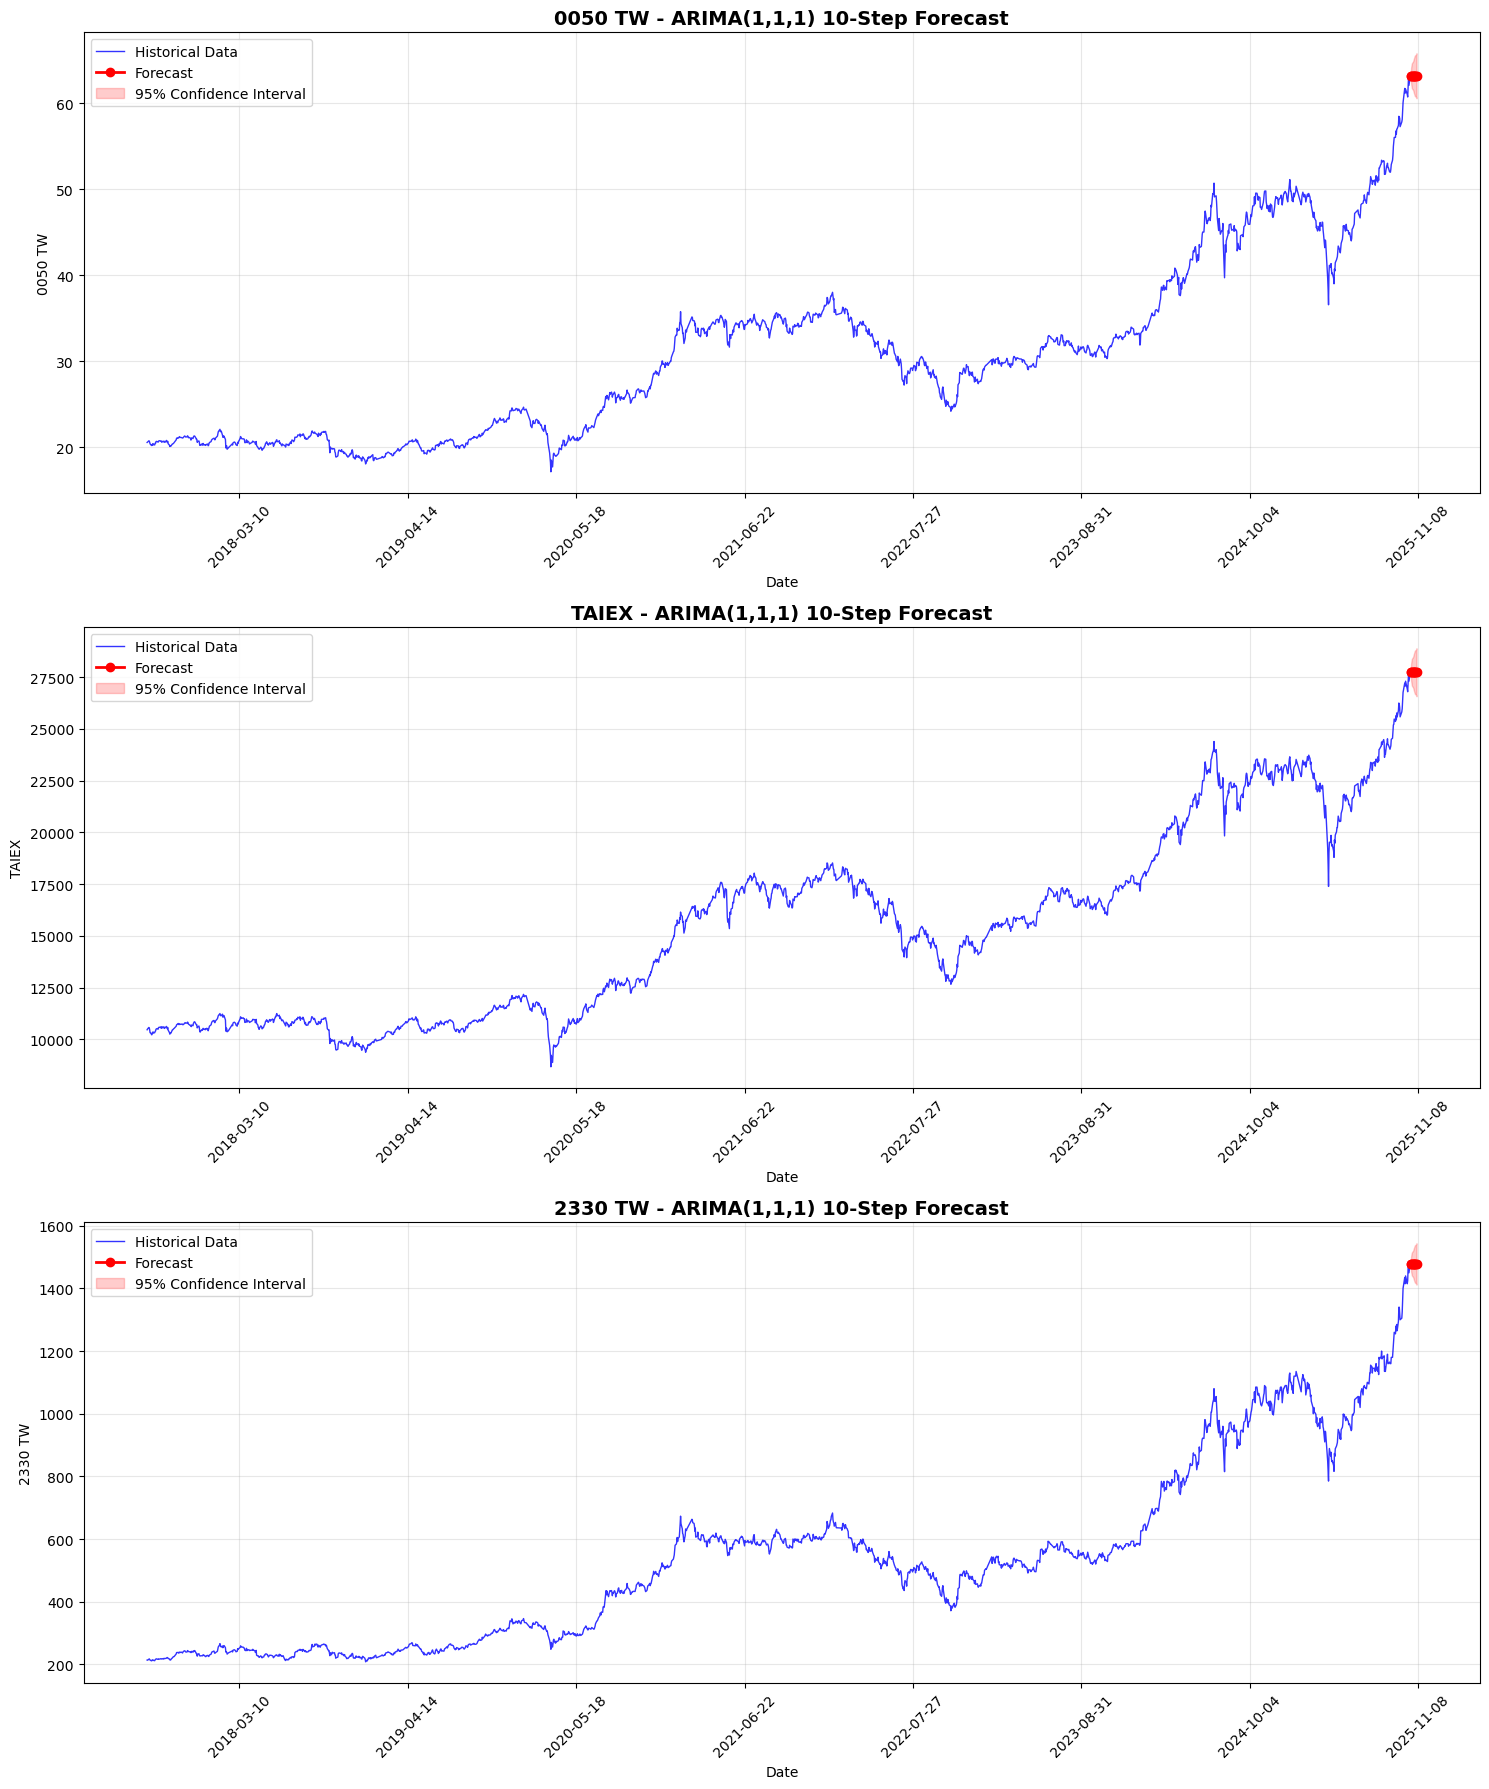

In [22]:
# ARIMA forecasting
forecast_steps = 10
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
models = {}

for i, col in enumerate(columns):
    print(f"\n=== ARIMA FORECASTING FOR {col} ===")
    
    # Check data sufficiency
    if len(df[col].dropna()) < 10:
        print(f"Skipping {col}: Insufficient data ({len(df[col].dropna())} rows)")
        continue
    
    try:
        # Fit ARIMA(1,1,1) model
        model = ARIMA(df[col], order=(2,1,1))
        result = model.fit()
        models[col] = result
        
        # Generate forecast
        forecast = result.get_forecast(steps=forecast_steps)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        
        # Create forecast dates
        last_date = df.index[-1]
        forecast_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=forecast_steps, freq='B')
        
        # Plot historical data
        axes[i].plot(df.index, df[col], 'b-', linewidth=1, label='Historical Data', alpha=0.8)
        
        # Plot forecast
        axes[i].plot(forecast_dates, forecast_mean, 'r-', linewidth=2, label='Forecast', marker='o')
        
        # Plot confidence intervals
        axes[i].fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                            color='red', alpha=0.2, label='95% Confidence Interval')
        
        # Formatting
        axes[i].set_title(f'{col} - ARIMA(1,1,1) 10-Step Forecast', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].xaxis.set_major_locator(plt.MaxNLocator(10))
        
        # Print forecast values
        print(f"\n{forecast_steps}-Step Forecast for {col}:")
        print("Step\tDate\t\tForecast\tLower CI\tUpper CI")
        print("-" * 50)
        for j in range(forecast_steps):
            date_str = forecast_dates[j].strftime('%Y-%m-%d')
            print(f"{j+1}\t{date_str}\t{forecast_mean.iloc[j]:8.3f}\t{forecast_ci.iloc[j, 0]:8.3f}\t{forecast_ci.iloc[j, 1]:8.3f}")
    
    except Exception as e:
        print(f"Error processing {col}: {e}")

plt.tight_layout()
try:
    plt.savefig('arima_forecasts_big3.png', dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving plot: {e}")
plt.show()

In [23]:
# Summary table
print("\n" + "="*60)
print("FORECAST SUMMARY TABLE")
print("="*60)
summary_data = []
for col in columns:
    if col in models:
        forecast = models[col].get_forecast(steps=1)
        forecast_mean = forecast.predicted_mean.iloc[0]
        summary_data.append([col, f"{forecast_mean:.3f}"])
summary_df = pd.DataFrame(summary_data, columns=['Series', '1-Step Forecast'])
print(summary_df.to_string(index=False))

print(f"\nAll forecasts generated from Excel file: {file_path}")
print(f"Data points used: {len(df)}")
print(f"Last date in data: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Forecast period: Next {forecast_steps} business days")


FORECAST SUMMARY TABLE
 Series 1-Step Forecast
0050 TW          63.179
  TAIEX       27744.643
2330 TW        1477.292

All forecasts generated from Excel file: F:\TW_0050 Research\Big 3 Data.xlsx
Data points used: 1994
Last date in data: 2025-10-21
Forecast period: Next 10 business days
